***

Analysis to predict wheather there will be rain tommorow or not is been done by using pyspark machine learning tools to visualise and predict the possibility of rainfall in australia.
***

***
# Part-A creating the spark session and loading the data.
***

***
## Step-1: Import the spark session and initialise spark
***

***
###  Importing and Initialising the Pyspark

Importing the required library and pyspark instilisation and importing it.
***

In [1]:
# create entry points to spark
from pyspark import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL
#importing the spark funstions
from pyspark.sql.functions import *
from pyspark.sql.functions import isnan,when ,count, col,avg,udf,collect_list
#from pyspark.sql import functions as F
# importing counter for count
from collections import Counter
#importing py spark types for casting
from pyspark.sql.types import *
# importing for feature selection
from pyspark.ml.feature import StringIndexer,VectorAssembler
# machine learning algorithms
from pyspark.ml.classification import DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,GBTClassifier
# evaluators of ml algorithms
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[4]", appName="Assignment2")
spark = SparkSession(sparkContext=sc)

***
## Step-2: Load the Dataset, print schema and count number of entries.
***

In [2]:
# create the spark data frame and load the data
weather_data = spark.read.csv("weatherAUS.csv", header=True )
print("Number of records in the Weather AUS:",weather_data.count())

Number of records in the Weather AUS: 142193


In [3]:
# schema for the data set
weather_data.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



***
# Part-B: Data cleaning and processing.
***

***
## Step-3: Deleting columns from the dataset.
***

In [4]:
# dropping the columns which are not needed for predictions
drop_col=['Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm']
#drooping the column in the list 'drop_col'
weather_df = weather_data.drop(*drop_col)
weather_df.show(10,truncate=False)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|13.4   |22.9   |0.6     |W          |44           |W         |WNW       |20          |24          |71         |22         |1007.7     |1007.1     |No       |No          |
|7.4    |25.1   |0       |WNW        |44           |NNW       |WSW       |4           |22          |44         |25         |1010.6     |1007.8     |No       |No          |
|12.9   |25.7   |0       |WSW        |46           |W         |WSW       |19          |26          |38         |30         |1007.6     |1008

***
## Step-4: Print the number of missing data in each column.
***

In [5]:
# checking for the 'NA' value in the each column and counting it.
weather_df.select([count(when(col(c)=='NA' , c)).alias(c) for c in weather_df.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



## Step-5: Fill the missing value with the Average value and Maximum occurrence.

***
### Identifying the wheather column is numeric or categorical variable
***

In [6]:
# list for numric column
numeric_columns=[]
#list for category column
category_column=[] 
# cating the column to interger
val= weather_df.select([col(c).cast('int').isNotNull().alias(c) for c in weather_df.columns])

# count if all the rows has been casted.
val = val.select([count(when(col(c).contains('true'),'val')).alias(c) for c in val.columns])
column_type = val.collect()
i=0
# if column has all the null value it means it is categorical variable
for c in val.columns:
   
    if column_type[0][i]==0:
        category_column.append(c)
    else:
        numeric_columns.append(c)
    i+=1

print("Numerical columns:",numeric_columns)
print("Categorical columns:",category_column)

Numerical columns: ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']
Categorical columns: ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


***
### Finding the average of all the numeric columns.
Here average of all the columns is calculated and added to dict 'new_d'
***

In [7]:
new_d={}
# data frame having the average of all the nnumeroc columns
mean_df = weather_df.select([avg(c).alias(c) for c in numeric_columns])
i=0
for c in mean_df.columns:
    # adding to dict
    new_d[c]=mean_df.collect()[0][i]
    i+=1


***
### Filling the missing value with average for numerical column,
mean of the columns is calculated and all the values in the numerical columns is replaced by mean of that column.
***

In [8]:
# all the 'NA' values in the columns in been replaced mean of the columns.
main_df = weather_df.withColumn('MinTemp',regexp_replace('MinTemp','NA',str(new_d['MinTemp'])))\
.withColumn('MaxTemp',regexp_replace('MaxTemp','NA',str(new_d['MaxTemp'])))\
.withColumn('Rainfall',regexp_replace('Rainfall','NA',str(new_d['Rainfall'])))\
.withColumn('WindGustSpeed',regexp_replace('WindGustSpeed','NA',str(new_d['WindGustSpeed'])))\
.withColumn('WindSpeed9am',regexp_replace('WindSpeed9am','NA',str(new_d['WindSpeed9am'])))\
.withColumn('WindSpeed3pm',regexp_replace('WindSpeed3pm','NA',str(new_d['WindSpeed3pm'])))\
.withColumn('Humidity9am',regexp_replace('Humidity9am','NA',str(new_d['Humidity9am'])))\
.withColumn('Humidity3pm',regexp_replace('Humidity3pm','NA',str(new_d['Humidity3pm'])))\
.withColumn('Pressure9am',regexp_replace('Pressure9am','NA',str(new_d['Pressure9am'])))\
.withColumn('Pressure3pm',regexp_replace('Pressure3pm','NA',str(new_d['Pressure3pm'])))


***
### Finding the Mode value of the categorical column.
***

In [9]:
# creating the user defined funcion to get the most frequent words
high_freq =udf(lambda x: Counter(x).most_common(1)[0][0]) 

# getting the most frequent value of each column
freq_val=[high_freq(collect_list(col)).alias(col) for col in category_column] 

main_df.groupBy().agg(*freq_val).show()

+-----------+----------+----------+---------+------------+
|WindGustDir|WindDir9am|WindDir3pm|RainToday|RainTomorrow|
+-----------+----------+----------+---------+------------+
|          W|         N|        SE|       No|          No|
+-----------+----------+----------+---------+------------+



In [10]:
# getting the mode for 'windGustDir'
high_freq_WindGustDir =str(main_df.groupBy().agg(*freq_val).collect().pop()['WindGustDir'])
# getting the mode for 'windGustDir9am'
high_freq_WindDir9am =str(main_df.groupBy().agg(*freq_val).collect().pop()['WindDir9am'])
# getting the mode for 'windGustDir3pm'
high_freq_WindDir3pm=str(main_df.groupBy().agg(*freq_val).collect().pop()['WindDir3pm'])
# getting the mode for 'RainToday'
high_freq_RainToday=str(main_df.groupBy().agg(*freq_val).collect().pop()['RainToday'])

***
### Replacing all the 'NA' value in the columns with the mode
***

In [11]:
# replacing all the 'NA' value in the categorical columns with the mode
main_df=main_df.withColumn('WindGustDir',regexp_replace('WindGustDir','NA',high_freq_WindGustDir))\
.withColumn('RainToday',regexp_replace('RainToday','NA',high_freq_RainToday))\
.withColumn('WindDir9am',regexp_replace('WindDir9am','NA',high_freq_WindDir9am))\
.withColumn('WindDir3pm',regexp_replace('WindDir3pm','NA',high_freq_WindDir3pm))

***
### Checking the Dataframe after imputation for the null value.
***

In [12]:
# checking if there are any null value in the dataframe
main_df.select([count(when(col(c)=='NA', c)).alias(c) for c in main_df.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|      0|      0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|        0|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



***
## Step-6 Data Tranformation.
***

***
### Typecasting the numeric column to the double.
All the numeric columns are converted to double.
***

In [13]:
#looping through all the numerical column and casting them to double.
for c in numeric_columns:
    main_df = main_df.withColumn(c, main_df[c].cast(DoubleType()))

In [14]:
main_df.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



***
### Using String Indexer to convert the non-numerical columns to the numeric values.
***

In [15]:
# looping through the non-numeric column and changing them to numeric value
for c in category_column:
    index = StringIndexer(inputCol=c,outputCol= c+'_index')
    main_df = index.fit(main_df).transform(main_df)

In [16]:
# dropping the non-numeric column
main_df = main_df.drop(*category_column)
# final dataframe schema
main_df.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- WindGustDir_index: double (nullable = false)
 |-- WindDir9am_index: double (nullable = false)
 |-- WindDir3pm_index: double (nullable = false)
 |-- RainToday_index: double (nullable = false)
 |-- RainTomorrow_index: double (nullable = false)



***
## Creating the feature vector and devide the dataset.
Using the vector assembler to featurized the dataframe and then keeping only those column which will be used for analysis. here, Traget which we will be predicting 'RainToday_index','RainTomorrow_index' are not involve in the vectorassembler or has been featurized.
***

In [17]:
# passing the parameters to vector assembler 
vec_assembler = VectorAssembler(inputCols=['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm',\
                                  'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','WindGustDir_index',\
                                 'WindDir9am_index','WindDir3pm_index'],
                       outputCol="features")
# tranforming the main dataframe
featurized_df = vec_assembler.transform(main_df)
# dropping the column and only keeping relevant column
featurized_df = featurized_df.drop('MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm',\
                                  'Humidity9am','Humidity3pm','Pressure9am','Pressure3pm','WindGustDir_index',\
                                 'WindDir9am_index','WindDir3pm_index')
featurized_df.show(truncate=False)

+---------------+------------------+-------------------------------------------------------------------------------------------+
|RainToday_index|RainTomorrow_index|features                                                                                   |
+---------------+------------------+-------------------------------------------------------------------------------------------+
|0.0            |0.0               |[13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,0.0,6.0,7.0]                         |
|0.0            |0.0               |[7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,9.0,9.0,3.0]                           |
|0.0            |0.0               |[12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,6.0,6.0,3.0]                         |
|0.0            |0.0               |[9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,13.0,1.0,10.0]                         |
|0.0            |0.0               |[17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,0.0,10.0

***
### Devide the dataframe into 70% train an 30% test dataset.
***

In [18]:
# devideing the main dataframe in 70-30 ratio
(train_data,test_data)= featurized_df.randomSplit([0.7, 0.3], seed = 100)
train_data.show(truncate=False)

+---------------+------------------+-------------------------------------------------------------------------------------------------------------+
|RainToday_index|RainTomorrow_index|features                                                                                                     |
+---------------+------------------+-------------------------------------------------------------------------------------------------------------+
|0.0            |0.0               |(13,[0,1,3,6,7,8,9],[-0.5,20.0,13.0,97.0,48.0,1022.8,1019.4])                                                |
|0.0            |0.0               |(13,[0,1,3,6,7,8,9],[-0.2,22.9,43.0,81.0,33.0,1018.6,1013.2])                                                |
|0.0            |0.0               |(13,[0,1,3,6,7,8,9],[0.6,19.2,31.0,79.0,38.0,1025.9,1021.2])                                                 |
|0.0            |0.0               |(13,[0,1,3,6,7,8,9],[0.9,15.0,13.0,100.0,59.0,1026.2,1022.9])                     

***
# Part-C Apply Machine Learning Algorithms
***

***
## Step-8  Apply machine learning alogorithms like DecisionTreeClassifier, RandomForestClassifier ,LogisticRegression, GBTClassifier.
***

***
### DecisionTress Classifier:

***

In [19]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="RainTomorrow_index", featuresCol="features")

# Train model.  
model = dt.fit(train_data)

# Make predictions.
predictions_decisiontree = model.transform(test_data)

# Select example rows to display.
predictions_decisiontree.select("prediction", "RainTomorrow_index", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrow_index", predictionCol="prediction", metricName="accuracy")
accuracy_decisiontree = evaluator.evaluate(predictions_decisiontree)
print("Test Error = %g " % (1.0 - accuracy_decisiontree))
print("Accuracy for the Decision Tree", accuracy_decisiontree)

+----------+------------------+--------------------+
|prediction|RainTomorrow_index|            features|
+----------+------------------+--------------------+
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
+----------+------------------+--------------------+
only showing top 5 rows

Test Error = 0.164723 
Accuracy for the Decision Tree 0.8352766588933644


***
### RainForest Classifier. 
***

In [20]:
rf = RandomForestClassifier(labelCol="RainTomorrow_index", featuresCol="features", numTrees=10)


# Train model. 
model = rf.fit(train_data)

# Make predictions.
predictions_rainforest = model.transform(test_data)

# Select example rows to display.
predictions_rainforest.select("RainTomorrow_index", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrow_index", predictionCol="prediction", metricName="accuracy")
accuracy_rainforest = evaluator.evaluate(predictions_rainforest)
print("Test Error = %g" % (1.0 - accuracy_rainforest))
print("Accuracy for Random Forest",accuracy_rainforest)


+------------------+--------------------+
|RainTomorrow_index|            features|
+------------------+--------------------+
|               0.0|(13,[0,1,3,6,7,8,...|
|               0.0|(13,[0,1,3,6,7,8,...|
|               0.0|(13,[0,1,3,6,7,8,...|
|               0.0|(13,[0,1,3,6,7,8,...|
|               0.0|(13,[0,1,3,6,7,8,...|
+------------------+--------------------+
only showing top 5 rows

Test Error = 0.166372
Accuracy for Random Forest 0.8336277766000048


***
### LogisticRegression.
***

In [21]:
lr = LogisticRegression(maxIter=10, featuresCol='features',labelCol='RainTomorrow_index')

# Fit the model
lrModel = lr.fit(train_data)
predictions_logistic=lrModel.transform(test_data)
predictions_logistic.select("prediction", "RainTomorrow_index", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrow_index", predictionCol="prediction", metricName="accuracy")
accuracy_logistic = evaluator.evaluate(predictions_logistic)
print("Test Error = %g" % (1.0 - accuracy_logistic))
print("Accuracy of logistic regression",accuracy_logistic)



+----------+------------------+--------------------+
|prediction|RainTomorrow_index|            features|
+----------+------------------+--------------------+
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
+----------+------------------+--------------------+
only showing top 5 rows

Test Error = 0.191058
Accuracy of logistic regression 0.8089416531222764


***
### Gradient Boost Trees Classifier.
***

In [22]:

# Train a GBT model.
gbt = GBTClassifier(labelCol="RainTomorrow_index", featuresCol="features", maxIter=10)

# Train model.  This also runs the indexers.
model = gbt.fit(train_data)

# Make predictions.
predictions_gradientboost = model.transform(test_data)

# Select example rows to display.
predictions_gradientboost.select("prediction", "RainTomorrow_index", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrow_index", predictionCol="prediction", metricName="accuracy")
accuracy_gradientboost = evaluator.evaluate(predictions_gradientboost)
print("Test Error = %g" % (1.0 - accuracy_gradientboost))
print('Accuracy of Gradient boost',accuracy_gradientboost)

+----------+------------------+--------------------+
|prediction|RainTomorrow_index|            features|
+----------+------------------+--------------------+
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
|       0.0|               0.0|(13,[0,1,3,6,7,8,...|
+----------+------------------+--------------------+
only showing top 5 rows

Test Error = 0.159824
Accuracy of Gradient boost 0.8401761948507761


***
### Comapring the accuracy of the 'Decion Tress','Random Forest','Logistic','Gradient Boost' machine learning algorithms.

Bar chart shows that gradient boost have the highest accuracy and Logisticregresser has the lowest accuracy.

***

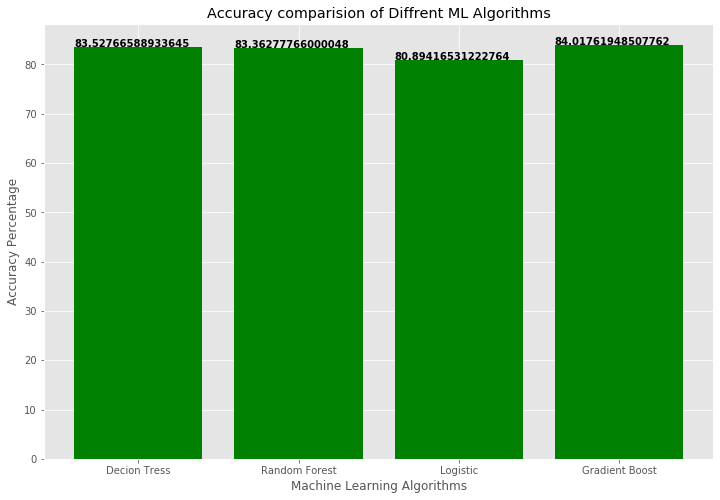

In [23]:
# importing the matplot library
import matplotlib.pyplot as plt
%matplotlib inline
#using ggplot
plt.style.use('ggplot')
# defining the x axis
x = ['Decion Tress','Random Forest','Logistic','Gradient Boost']

# adding the y axis
accuracy = [accuracy_decisiontree,accuracy_rainforest,accuracy_logistic,accuracy_gradientboost]

# refactoring the y axis for %
accuracy[:]=[i*100 for i in accuracy]
x_pos = [i for i, _ in enumerate(x)]

# setting the figure size
plt.figure(figsize=(12,8))

#ploting the bar chart
bar=plt.bar(x_pos, accuracy, color='green')

# adding the text to the bar chart
for i in bar:
    plt.text(i.get_x(),i.get_height(),str(i.get_height()),fontweight='bold')
    
plt.xlabel("Machine Learning Algorithms")
plt.ylabel("Accuracy Percentage")
plt.title("Accuracy comparision of Diffrent ML Algorithms")
plt.xticks(x_pos, x)
plt.show()

***
## Step-9: Calculate the confusion matrix find the precision, recall, f1score of each classifier algorithm. Explain how the accuracy of prediction can be improved.
***

In [24]:
# creating the confusion matrix for Decision Tree Classifier
def create_confusion_metrix(dataframe,algo_name):
        
    df_rdd = dataframe.select("prediction", "RainTomorrow_index").rdd.map(lambda line: (line[1], line[0]))
    multiclass_metrics = MulticlassMetrics(df_rdd)

    # Confusion Matrix
    confusion_matrix=multiclass_metrics.confusionMatrix().toArray()
    print("The Confusion Matrix of",algo_name+":")
    print(confusion_matrix)


    # precision
    precision=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[0][1])
    # recall
    recall=(confusion_matrix[0][0])/(confusion_matrix[0][0]+confusion_matrix[1][0])
    #f1score
    f1Score = (2*precision*recall)/(precision+recall)

    print("\n")
    print("Summary Statistics of",algo_name+":")
    print("Precision = ",precision)
    print("Recall = " ,recall)
    print("F1 Score = ",f1Score)

***
### Confusion matrix for Decision Tree.
***

In [25]:
# confusion matrix for decision tree
create_confusion_metrix(predictions_decisiontree,"Decision Tree")

The Confusion Matrix of Decision Tree:
[[31196.  5363.]
 [ 1630.  4264.]]


Summary Statistics of Decision Tree:
Precision =  0.8533056155802948
Recall =  0.9503442393224882
F1 Score =  0.8992145276356561


***
### Confusion matrix for Rainforest classifier.
***

In [26]:
# confusion matrix for rainforest
create_confusion_metrix(predictions_rainforest,"Rainforest classifier")

The Confusion Matrix of Rainforest classifier:
[[31636.  5873.]
 [ 1190.  3754.]]


Summary Statistics of Rainforest classifier:
Precision =  0.8434242448479031
Recall =  0.9637482483397307
F1 Score =  0.8995805786592734


***
### Confusion matrix for Logistic Regression.
***

In [27]:
create_confusion_metrix(predictions_logistic,"Logistic Regression")

The Confusion Matrix of Logistic Regression:
[[32126.  7411.]
 [  700.  2216.]]


Summary Statistics of Logistic Regression:
Precision =  0.8125553279206819
Recall =  0.9786754401998415
F1 Score =  0.8879123308873319


***
### Confusion matrix GBTClassifier.
***

In [28]:
create_confusion_metrix(predictions_gradientboost,"GBTClassifier")

The Confusion Matrix of GBTClassifier:
[[31209.  5168.]
 [ 1617.  4459.]]


Summary Statistics of GBTClassifier:
Precision =  0.857932209912857
Recall =  0.950740266861634
F1 Score =  0.9019551175527072


### Explain how the accuracy of prediction can be improved.

- **Feature selection:**
Initially we have removed some of the columns, like humidity which could be one of the factors affecting the rainfall and further improve the accuracy of the Machine learning algorithms. we could further use the exploratory data anaysis and features selections tools such as correlation matrix,PCA etc to determine the best features for improving the accuracy.
- **Ensemble Methods:** 
It is the machine technique of combining the prediction of the multiple columns. By combining knowledge of muktiple model will give more accurate results. we could use either bagging or bossting ensembler techniques to achieve the higher accuracy.
- ***Feature Engineering*** It helps to extract the more inforamation from the data.
    - **Feature Transform:** Changing the scale of the variable for the column called as data normalisation or remove the skewness of the variable as some algorithms works well with the normal distributed data.
    - **Feature Creation:** Extrating the new variable from the existing one. like from the 'week' variable we could extract the 'day' variable.
- **Algorithm Tunning:** ML algorithms are drive by the parameters whose optimal value could gretly influence accurancy. For example in rain forest classifier optimisation of parameters like 'number_trees','random_state','max_feature' could helps in achieve greater accuracy.

# References:

1.  https://spark.apache.org/docs/2.0.0/api/python/pyspark.mllib.html 

2.  https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe 

3. https://stackoverflow.com/questions/46956026/how-to-convert-column-with-string-type-to-int-form-in-pyspark-data-frame 

